In [43]:
# Import the required libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import datetime
from matplotlib.dates import DateFormatter
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


In [44]:
parameters = [
    {'name': 'rh', 'label': 'Relative Humidity', 'unit': '%'},
    {'name': 'pm1', 'label': 'PM\u2081', 'unit': 'µg/m\u00b3'},
    {'name': 'pm25', 'label': 'PM\u2082.\u2085', 'unit': 'µg/m\u00b3'},
    {'name': 'pm10', 'label': 'PM\u2081\u2080', 'unit': 'µg/m\u00b3'},
    {'name': 'temp', 'label': 'Temperature', 'unit': '°C'}
]

In [45]:
def remove_outliers(df, column_name):
    # Calculate the mean of the column
    mean_value = df[column_name].mean()

    # Define the upper threshold (4 to 5 times the mean)
    upper_threshold =40 * mean_value

    # Filter the data and keep only rows with values within the threshold
    filtered_df = df[df[column_name] <= upper_threshold]

    return filtered_df



In [46]:
scaler =  MinMaxScaler()
dfMod_april = pd.read_csv('April_data/outdoor_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfAlp_april = pd.read_csv('April_data/alpha_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfBet_april = pd.read_csv('April_data/beta_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')

dfMod_may = pd.read_csv('May_data/outdoor_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfAlp_may = pd.read_csv('May_data/alpha_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
dfBet_may = pd.read_csv('May_data/beta_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')

dfAlp = pd.concat([dfAlp_april,dfAlp_may])
dfBet = pd.concat([dfBet_april,dfBet_may])
dfMod = pd.concat([dfMod_april,dfMod_may])

dfAlp.rename(columns={'timestamp_local':'Date'},inplace=True)
dfBet.rename(columns={'timestamp_local':'Date'},inplace=True)
dfAlp.rename(columns={'sample_rh':'rh'},inplace=True)
dfBet.rename(columns={'sample_rh':'rh'},inplace=True)
dfAlp.rename(columns={'sample_temp':'temp'},inplace=True)
dfBet.rename(columns={'sample_temp':'temp'},inplace=True)
dfMod.index = dfMod.index.map(lambda x: x.replace(second=0))
dfAlp.index = dfAlp.index.map(lambda x: x.replace(second=0))
dfBet.index = dfBet.index.map(lambda x: x.replace(second=0))


dfAlp = remove_outliers(dfAlp,'pm10')
dfBet = remove_outliers(dfBet,'pm10')
dfMod = remove_outliers(dfMod,'pm10')


OG_dfAlp = dfAlp.iloc[::-1]
OG_dfBet = dfBet.iloc[::-1]
OG_dfMod = dfMod.iloc[::-1]


OG_dfMod = OG_dfMod[OG_dfMod['pm10'] > 0]
OG_dfAlp = OG_dfAlp[OG_dfAlp['pm10'] > 0]   
OG_dfBet = OG_dfBet[OG_dfBet['pm10'] > 0]


OG_dfMod = OG_dfMod[OG_dfMod['pm25'] > 0]
OG_dfAlp = OG_dfAlp[OG_dfAlp['pm25'] > 0]   
OG_dfBet = OG_dfBet[OG_dfBet['pm25'] > 0]



OG_dfMod = OG_dfMod[OG_dfMod['pm1'] > 0]
OG_dfAlp = OG_dfAlp[OG_dfAlp['pm1'] > 0]   
OG_dfBet = OG_dfBet[OG_dfBet['pm1'] > 0]

common_timestamps = OG_dfMod.index.intersection(OG_dfAlp.index).intersection(OG_dfBet.index)

# Filter each DataFrame to keep only the rows with common timestamps
OG_dfMod = OG_dfMod[dfMod.index.isin(common_timestamps)]
OG_dfAlp = OG_dfAlp[dfAlp.index.isin(common_timestamps)]
OG_dfBet = OG_dfBet[dfBet.index.isin(common_timestamps)]

for parameter in parameters:
    max_Mod = OG_dfMod[parameter['name']].max()
    OG_dfAlp[parameter['name']] = OG_dfAlp[parameter['name']]/max_Mod
    OG_dfBet[parameter['name']] = OG_dfBet[parameter['name']]/max_Mod
    OG_dfMod[parameter['name']] = OG_dfMod[parameter['name']]/max_Mod




print(len(OG_dfMod), len(OG_dfAlp), len(OG_dfBet))


print(.8*len(OG_dfAlp))

train_slice = slice(5000,int(.8*len(OG_dfAlp)))
test_slice = slice(int(.8*len(OG_dfAlp)),len(OG_dfMod))
train_dfAlp = OG_dfAlp[5000:int(.8*len(OG_dfAlp))]
train_dfBet = OG_dfBet[5000:int(.8*len(OG_dfAlp))]
train_dfMod = OG_dfMod[5000:int(.8*len(OG_dfAlp))]

print(len(train_dfMod),len(train_dfAlp),len(train_dfBet))


78427 78428 78427
62742.4
57742 57742 57742


In [47]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [ 'sqrt', 'log2'],
    


}

In [48]:


# # Common preprocessing steps
# def preprocess_data(df):
#     df['temp'] = df['temp'].astype(float)
#     df['rh'] = df['rh'].astype(float)
#     df['log_rh'] = np.log(df['rh'])

# parameters = parameters[1:4]  # Assuming 'parameters' is defined

# # Preprocess training data for Alpha and Beta models
# preprocess_data(train_dfAlp)
# preprocess_data(train_dfBet)

# # Create a single GridSearchCV instance for Alpha and Beta models
# alpha_grid_search = GridSearchCV(RandomForestRegressor(), param_grid)
# beta_grid_search = GridSearchCV(RandomForestRegressor(), param_grid)

# alpha_regressor = {}
# beta_regressor = {}

# # Loop through each parameter
# for parameter in parameters:
#     parameter_name = parameter['name']
#     print(parameter_name)
#     # Preprocess training data for Alpha model
#     X_alpha = train_dfAlp[[parameter_name, 'temp', 'log_rh']]
#     y_alpha = train_dfMod[parameter_name]
#     alpha_grid_search.fit(X_alpha, y_alpha)
#     alpha_regressor[parameter_name] = alpha_grid_search.best_params_

#     alpha_regressor[parameter_name] = RandomForestRegressor(**alpha_regressor[parameter_name])
#     alpha_regressor[parameter_name].fit(X_alpha, y_alpha)

#     # Preprocess training data for Beta model
#     X_beta = train_dfBet[[parameter_name,'temp', 'log_rh']]
#     y_beta = train_dfMod[parameter_name]
#     beta_grid_search.fit(X_beta, y_beta)
#     beta_regressor[parameter_name] = beta_grid_search.best_params_
#     beta_regressor[parameter_name] = RandomForestRegressor(**beta_regressor[parameter_name])
#     beta_regressor[parameter_name].fit(X_beta, y_beta)





In [49]:


# Common preprocessing steps
def preprocess_data(df):
    df['log_rh'] = np.log(df['rh'])

parameters = parameters[1:4]  # Assuming 'parameters' is defined

# Preprocess training data for Alpha and Beta models
preprocess_data(train_dfAlp)
preprocess_data(train_dfBet)


alpha_regressor = {}
beta_regressor = {}

# Loop through each parameter
for parameter in parameters:
    parameter_name = parameter['name']
    
    # Preprocess training data for Alpha model
    X_alpha = train_dfAlp[[parameter_name, 'temp', 'log_rh']]
    y_alpha = train_dfMod[parameter_name]

    alpha_regressor[parameter_name] = RandomForestRegressor()
    alpha_regressor[parameter_name].fit(X_alpha, y_alpha)

    # Preprocess training data for Beta model
    X_beta = train_dfBet[[parameter_name,'temp', 'log_rh']]
    y_beta = train_dfMod[parameter_name]

    beta_regressor[parameter_name] = RandomForestRegressor()
    beta_regressor[parameter_name].fit(X_beta, y_beta)




/tmp/ipykernel_4646/842577831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_rh'] = np.log(df['rh'])
/tmp/ipykernel_4646/842577831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_rh'] = np.log(df['rh'])


In [50]:
test_dfAlp = OG_dfAlp[test_slice]
test_dfBet = OG_dfBet[test_slice]
test_dfMod =  OG_dfMod[test_slice]

test_dfAlp['log_rh'] = np.log(test_dfAlp['rh'])
test_dfBet['log_rh'] = np.log(test_dfBet['rh'])
for parameter in parameters[1:4]:
    test_dfAlp["new "+ parameter["name"]] = alpha_regressor[parameter["name"]].predict(test_dfAlp[[parameter["name"],"temp","log_rh"]])
    test_dfBet["new " +parameter["name"]] = beta_regressor[parameter["name"]].predict(test_dfBet[[parameter["name"],"temp","log_rh"]])
    

/tmp/ipykernel_4646/4129258290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfAlp['log_rh'] = np.log(test_dfAlp['rh'])
/tmp/ipykernel_4646/4129258290.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfBet['log_rh'] = np.log(test_dfBet['rh'])
/tmp/ipykernel_4646/4129258290.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [51]:
# new_dfAlp = pd.read_csv('May_data/alpha_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
# new_dfBet = pd.read_csv('May_data/beta_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')
# new_dfMod = pd.read_csv('May_data/outdoor_may.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')

# new_dfAlp = new_dfAlp.iloc[::-1]
# new_dfBet = new_dfBet.iloc[::-1]
# new_dfMod = new_dfMod.iloc[::-1]

# new_dfMod = remove_outliers(new_dfMod, 'pm10')
# new_dfAlp = remove_outliers(new_dfAlp, 'pm10')
# new_dfBet = remove_outliers(new_dfBet, 'pm10')
# # new_dfAlp = new_dfAlp[0:10000]
# # new_dfBet = new_dfBet[0:10000]
# # new_dfMod = new_dfMod[0:10000]

# # new_dfAlp = pd.read_csv('April_data/alpha_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')[25000:40000]
# # new_dfBet = pd.read_csv('April_data/beta_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')[25000:40000]
# # new_dfMod = pd.read_csv('April_data/outdoor_april.csv',parse_dates=['timestamp_local'],index_col='timestamp_local')[25000:40000]

# new_dfAlp.index = new_dfAlp.index.map(lambda x: x.replace(second=0))
# new_dfBet.index = new_dfBet.index.map(lambda x: x.replace(second=0))
# new_dfMod.index = new_dfMod.index.map(lambda x: x.replace(second=0))

# new_dfAlp.rename(columns={'sample_rh':'rh'},inplace=True)
# new_dfBet.rename(columns={'sample_rh':'rh'},inplace=True)
# new_dfAlp.rename(columns={'sample_temp':'temp'},inplace=True)
# new_dfBet.rename(columns={'sample_temp':'temp'},inplace=True)

# common_timestamps = new_dfMod.index.intersection(new_dfAlp.index).intersection(new_dfBet.index)

# # Filter each DataFrame to keep only the rows with common timestamps
# new_dfMod = new_dfMod[new_dfMod.index.isin(common_timestamps)]
# new_dfAlp = new_dfAlp[new_dfAlp.index.isin(common_timestamps)]
# new_dfBet = new_dfBet[new_dfBet.index.isin(common_timestamps)]


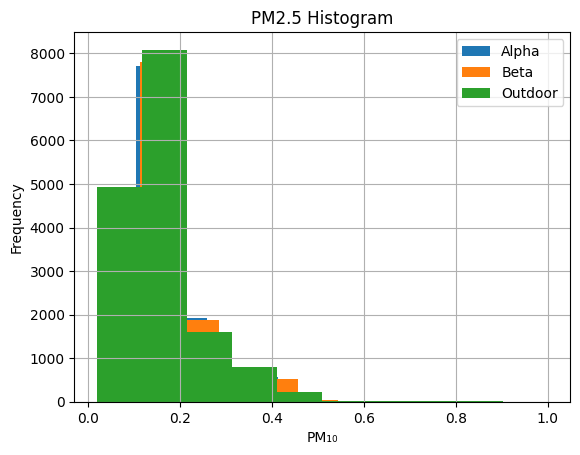

In [52]:
test_dfAlp["pm25"].hist(label="Alpha")
test_dfBet["pm25"].hist(label="Beta")
test_dfMod["pm25"].hist(label="Outdoor")
plt.ylabel("Frequency")
plt.xlabel(parameters[2]["label"])
plt.title("PM2.5 Histogram")
plt.legend()
plt.show()


/tmp/ipykernel_4646/2707616318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/2707616318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfAlp[f'60 mean {parameter["name"]}']=test_dfAlp[parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/2707616318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

PM₂.₅ P-Value Alpha: 3.0182043758124233e-62
PM₂.₅ P-Value Beta: 4.76054011933735e-06


/tmp/ipykernel_4646/2707616318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/2707616318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfAlp[f'60 mean {parameter["name"]}']=test_dfAlp[parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/2707616318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

PM₁₀ P-Value Alpha: 0.000844856370779097
PM₁₀ P-Value Beta: 0.011298543046701293


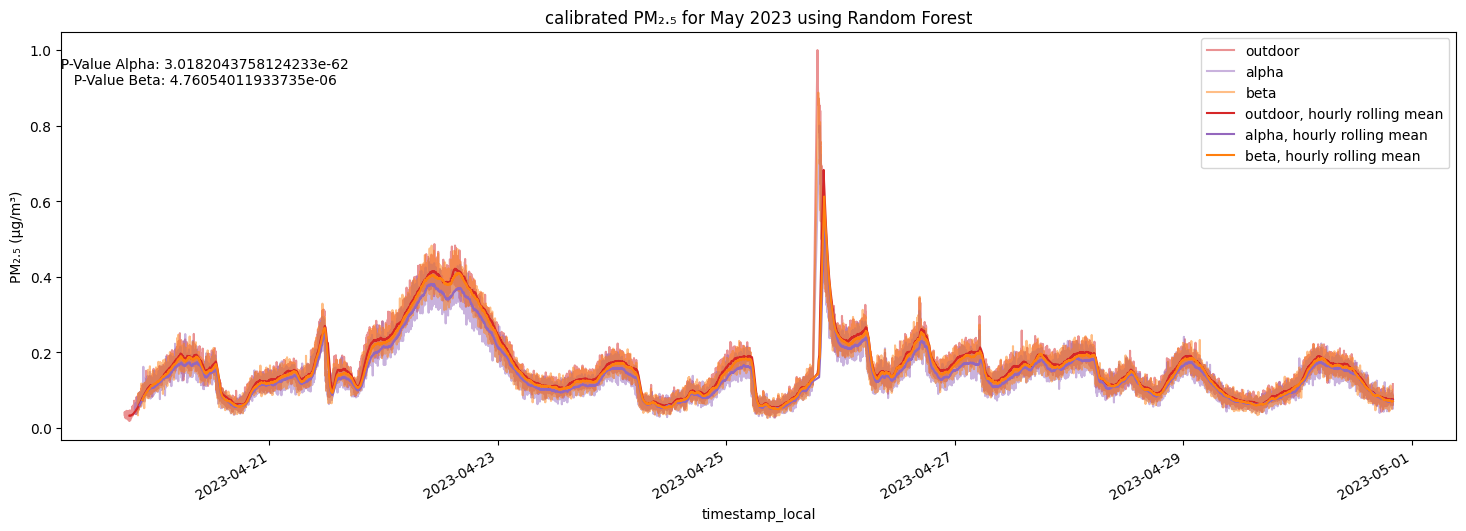

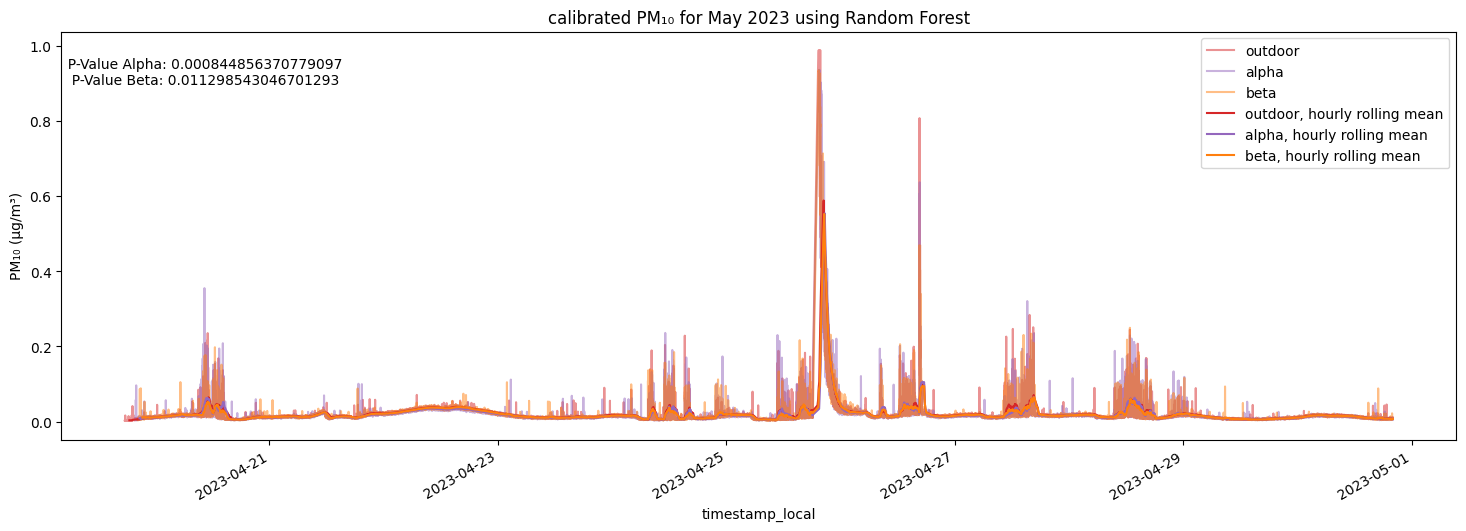

In [53]:
for parameter in parameters[1:4]:
    test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
    test_dfAlp[f'60 mean {parameter["name"]}']=test_dfAlp[parameter['name']].rolling(60).mean()
    test_dfBet[f'60 mean {parameter["name"]}']=test_dfBet[parameter['name']].rolling(60).mean()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'calibrated {parameter["label"]} for May 2023 using Random Forest')
    plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
    
    
    _, p_value_alpha = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfAlp[parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfBet[parameter["name"]], equal_var=False)
    plt.text(0.1, 0.9, f'  P-Value Alpha: {p_value_alpha}\n  P-Value Beta: {p_value_beta}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

    test_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
    test_dfAlp[parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
    test_dfBet[parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
    test_dfMod[f'60 mean {parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    test_dfAlp[f'60 mean {parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    test_dfBet[f'60 mean {parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()


    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)

/tmp/ipykernel_4646/3266508088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/3266508088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfAlp[f'60 mean {"new " + parameter["name"]}']=test_dfAlp["new " + parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/3266508088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

PM₂.₅ P-Value Alpha: 3.0182043758124233e-62
PM₂.₅ P-Value Beta: 4.76054011933735e-06


/tmp/ipykernel_4646/3266508088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/3266508088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfAlp[f'60 mean {"new " + parameter["name"]}']=test_dfAlp["new " + parameter['name']].rolling(60).mean()
/tmp/ipykernel_4646/3266508088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

PM₁₀ P-Value Alpha: 0.000844856370779097
PM₁₀ P-Value Beta: 0.011298543046701293


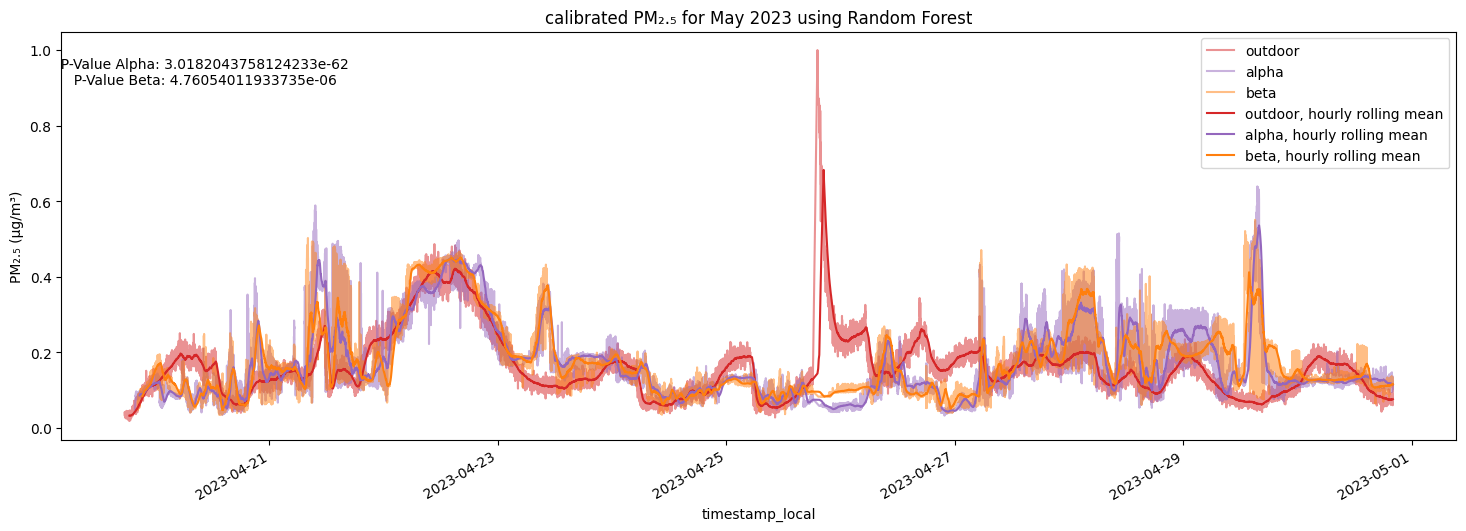

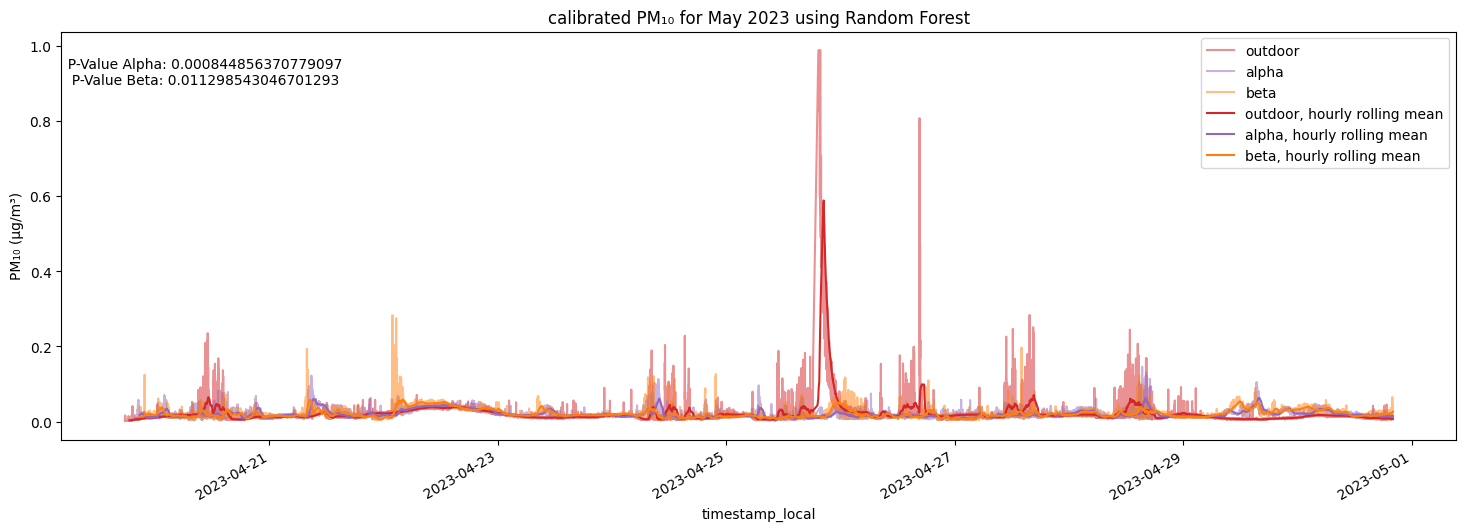

In [54]:
for parameter in parameters[1:4]:
    test_dfMod[f'60 mean {parameter["name"]}']=test_dfMod[parameter['name']].rolling(60).mean()
    test_dfAlp[f'60 mean {"new " + parameter["name"]}']=test_dfAlp["new " + parameter['name']].rolling(60).mean()
    test_dfBet[f'60 mean {"new " + parameter["name"]}']=test_dfBet["new " + parameter['name']].rolling(60).mean()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.gcf().set_size_inches(18, 6)
    plt.title(f'calibrated {parameter["label"]} for May 2023 using Random Forest')
    plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
    plt.xlabel('Time (days)')
    plt.grid(True)
    
    
    _, p_value_alpha = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfAlp[parameter["name"]], equal_var=False)
    _, p_value_beta = stats.ttest_ind(test_dfMod[parameter["name"]], test_dfBet[parameter["name"]], equal_var=False)
    plt.text(0.1, 0.9, f'  P-Value Alpha: {p_value_alpha}\n  P-Value Beta: {p_value_beta}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

    test_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
    test_dfAlp["new " + parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
    test_dfBet["new " + parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
    test_dfMod[f'60 mean { parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
    test_dfAlp[f'60 mean {"new " + parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
    test_dfBet[f'60 mean {"new " + parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
    plt.legend()


    print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
    print(f"{parameter['label']} P-Value Beta:", p_value_beta)

0.05827706692948542
0.06203729888671806
0.005987366754717609
0.006122763857946361


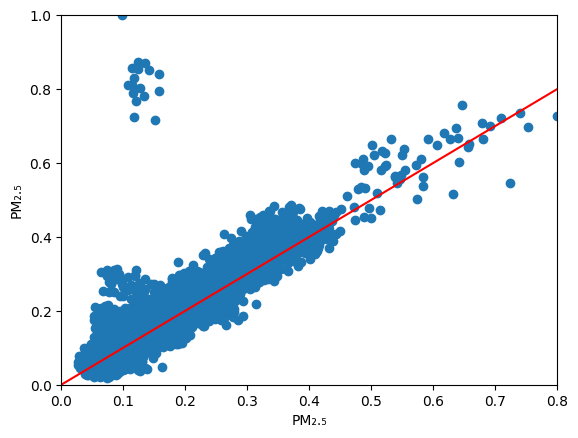

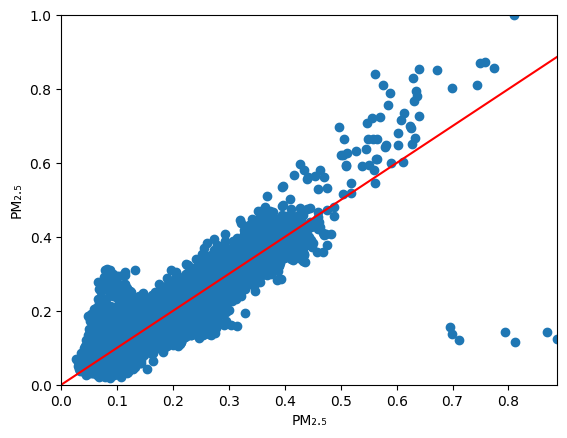

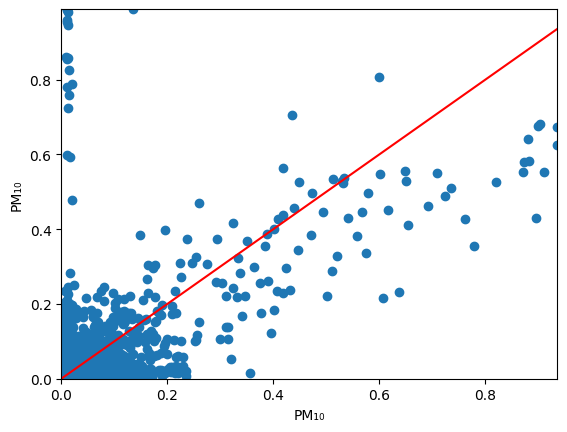

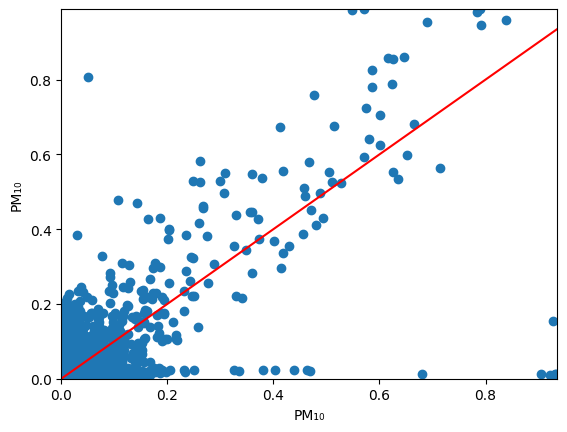

In [55]:

x = np.linspace(0, 100, 1000)
y = np.linspace(0, 100, 1000)

for parameter in parameters[1:4]:
    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfAlp[parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfAlp)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')
    
    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfAlp)]))
    plt.xlim(0, max(test_dfAlp[parameter["name"]]))
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])

    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfBet[parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfBet)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')

    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfBet)]))
    plt.xlim(0, max(test_dfBet[parameter["name"]]))
    
    
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])


    
    print(np.mean(test_dfAlp[parameter["name"]][:len(dfAlp)]/dfMod[parameter["name"]][:len(dfAlp)]))
    print(np.mean(test_dfBet[parameter["name"]][:len(dfBet)]/dfMod[parameter["name"]][:len(dfBet)]))

0.07643780322022115
0.07894956450636036
0.008841436165101291
0.009082511620706163


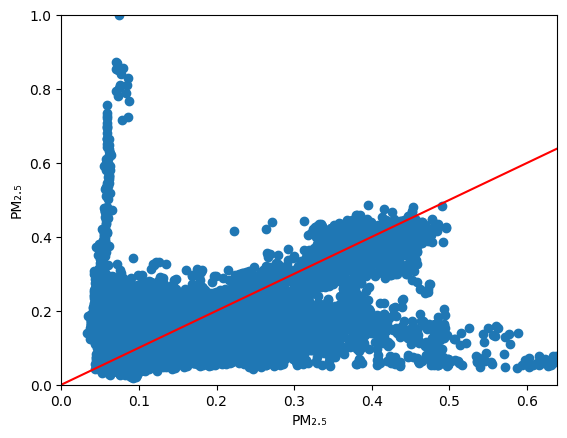

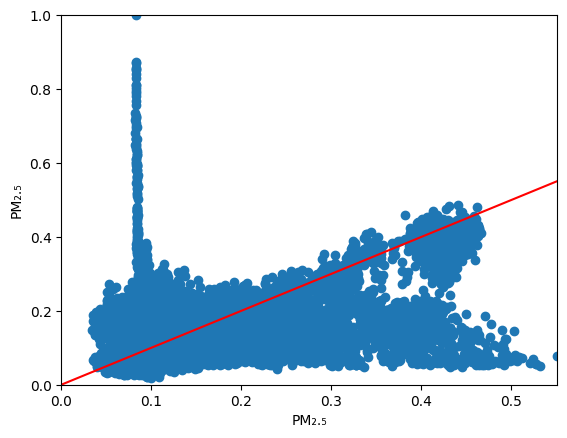

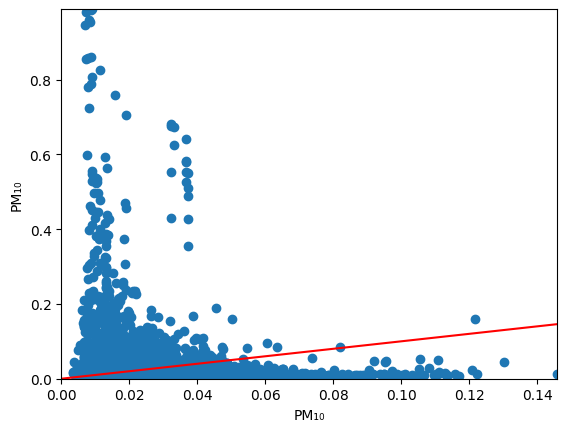

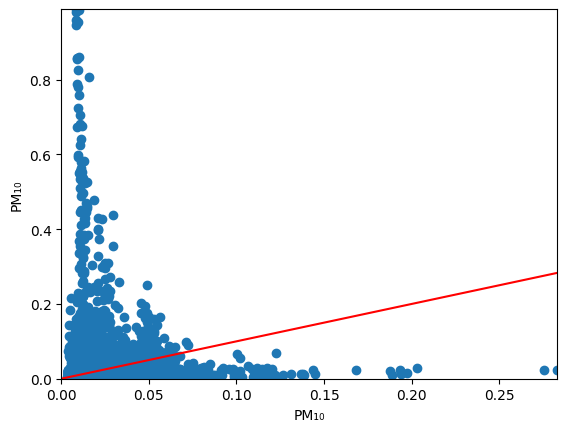

In [56]:


x = np.linspace(0, 100, 1000)
y = np.linspace(0, 100, 1000)

for parameter in parameters[1:4]:
    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfAlp["new " + parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfAlp)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')
    
    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfAlp)]))
    plt.xlim(0, max(test_dfAlp["new " + parameter["name"]]))
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])

    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.plot(test_dfBet["new " + parameter["name"]],test_dfMod[parameter["name"]][:len(test_dfBet)], 'o', label='Original data')
    plt.plot(x, y, 'r', label='Fitted line')

    plt.ylim(0, max(test_dfMod[parameter["name"]][:len(test_dfBet)]))
    plt.xlim(0, max(test_dfBet["new " + parameter["name"]]))
    
    
    plt.xlabel(parameter["label"])
    plt.ylabel(parameter["label"])


    
    
    print(np.mean(test_dfAlp["new " +parameter["name"]][:len(dfAlp)]/dfMod[parameter["name"]][:len(dfAlp)]))
    print(np.mean(test_dfBet["new " +parameter["name"]][:len(dfBet)]/dfMod[parameter["name"]][:len(dfBet)]))

In [57]:
# for parameter in parameters[1:4]:
#     new_dfMod[f'60 mean {parameter["name"]}']=new_dfMod[parameter['name']].rolling(60).mean()
#     new_dfAlp[f'60 mean {parameter["name"]}']=new_dfAlp[parameter['name']].rolling(60).mean()
#     new_dfBet[f'60 mean {parameter["name"]}']=new_dfBet[parameter['name']].rolling(60).mean()

#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.gcf().set_size_inches(18, 6)
#     plt.title(f'Uncalibrated {parameter["label"]} for May 2023')
#     plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
#     plt.xlabel('Time (days)')
#     plt.grid(True)
    

   

#     new_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
#     new_dfAlp[parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
#     new_dfBet[parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
#     new_dfMod[f'60 mean {parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
#     new_dfAlp[f'60 mean {parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
#     new_dfBet[f'60 mean {parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
#     plt.legend()

#     _, p_value_alpha = stats.ttest_ind(new_dfMod[parameter["name"]], new_dfAlp[parameter["name"]], equal_var=False)
#     _, p_value_beta = stats.ttest_ind(new_dfMod[parameter["name"]], new_dfBet[parameter["name"]], equal_var=False)

#     print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
#     print(f"{parameter['label']} P-Value Beta:", p_value_beta)



In [58]:
# for parameter in parameters[1:4]:
#     new_dfAlp[parameter['name']]=alpha_clf[parameter['name']].predict(new_dfAlp[[parameter["name"],"temp","rh"]])
#     new_dfBet[parameter['name']]=beta_clf[parameter['name']].predict(new_dfBet[[parameter["name"],"temp","rh"]])


In [59]:
# for parameter in parameters[1:4]:
#     new_dfMod[f'60 mean {parameter["name"]}']=new_dfMod[parameter['name']].rolling(60).mean()
#     new_dfAlp[f'60 mean {parameter["name"]}']=new_dfAlp[parameter['name']].rolling(60).mean()
#     new_dfBet[f'60 mean {parameter["name"]}']=new_dfBet[parameter['name']].rolling(60).mean()

#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.gcf().set_size_inches(18, 6)
#     plt.title(f'calibrated {parameter["label"]} for May 2023 using Random Forest')
#     plt.ylabel(f'{parameter["label"]} ({parameter["unit"]})')
#     plt.xlabel('Time (days)')
#     plt.grid(True)
#     plt.ylim(0, 20)

   

#     new_dfMod[parameter["name"]].plot(color='tab:red', label='outdoor', alpha=0.5)
#     new_dfAlp[parameter["name"]].plot(color='tab:purple', label='alpha', alpha=0.5)
#     new_dfBet[parameter["name"]].plot(color='tab:orange', label='beta', alpha=0.5)
#     new_dfMod[f'60 mean {parameter["name"]}'].plot(color='tab:red', label='outdoor, hourly rolling mean')
#     new_dfAlp[f'60 mean {parameter["name"]}'].plot(color='tab:purple', label='alpha, hourly rolling mean')
#     new_dfBet[f'60 mean {parameter["name"]}'].plot(color='tab:orange', label='beta, hourly rolling mean')
#     plt.legend()

#     _, p_value_alpha = stats.ttest_ind(new_dfMod[parameter["name"]], new_dfAlp[parameter["name"]], equal_var=False)
#     _, p_value_beta = stats.ttest_ind(new_dfMod[parameter["name"]], new_dfBet[parameter["name"]], equal_var=False)

#     print(f"{parameter['label']} P-Value Alpha:", p_value_alpha)
#     print(f"{parameter['label']} P-Value Beta:", p_value_beta)

In [60]:
# dfMod["pm25"].hist()
# dfAlp["pm25"].hist()
# dfBet["pm25"].hist()

In [ ]:
print